# Script to predict glacier-wide mass balance from ML model

In [91]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde
from pyproj import Proj, transform

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

from model_classes import CustomXGBRegressor
from sklearn.utils.validation import check_is_fitted



## Helper functions

In [40]:
# Get modelled mass balance from xarray Dataset based on 
# dataframe of point mass balances

def get_modelled_mb(df, ds, type):
    """
    df : pd.DataFrame of point mb (mass balance)
    ds : xr.DataSet of modelled mass balance
    type : str, variable in ds; 'mb_annual', 'mb_summer', or 'mb_winter'
    """
    
    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        # Use the attributes of namedtuple
        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        # Check if the current_year_dt is in the 'time' coordinate of the dataset
        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            # Check if current_id exists in the 'ID' coordinate of the dataset
            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:
            # If modelled mb is not available for the current year, use nan
            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


In [41]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [42]:
def get_ytrue_y_pred_agg_season(y_true, y_pred, X, months=12):

    # Get values for the given season
    mask = X[:, -2] == months  
    X = X[mask] 
    
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [43]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

## Prepare topographical features for glacier

In [21]:
filepath_topo = 'Data/oggm_data/per_glacier/RGI60-08/RGI60-08.01/RGI60-08.01126/'
filename_grid = 'gridded_data.nc'
glacier_id = 2297

In [22]:
with xr.open_dataset(filepath_topo + filename_grid) as ds_out:
    ds = ds_out

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\Users\\kasj\\ML_MB_Norway\\Data\\oggm_data\\per_glacier\\RGI60-08\\RGI60-08.01\\RGI60-08.01126\\gridded_data.nc'

In [ ]:
ds

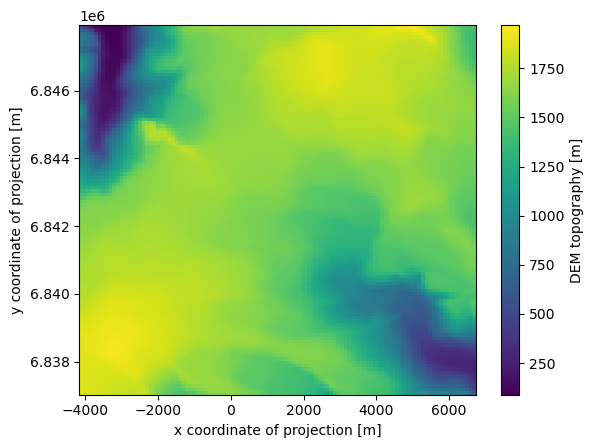

In [17]:
ds.topo.plot()

In [53]:
# Get glacier mask (ones) as numpy array
#mask = ds.glacier_mask.values

# Get glacier elevation as numpy array
#elev = ds.topo.values 

# Get array of elevation in glacier grid cells
#masked_elev = elev * mask

# Get vector of elevation in glacier grid cells
#masked_elev_vec = masked_elev[masked_elev>0]

In [62]:
# Assuming ds is your xarray dataset and 'glacier_mask' and 'topo' are the variable names
glacier_mask = ds['glacier_mask'].values  # Retrieve the glacier mask as a numpy array
elev = ds['topo'].values  # Retrieve the elevation data as a numpy array
slope = ds['slope'].values
aspect = ds['aspect'].values

# Ensure the mask is interpreted correctly as a boolean array
glacier_mask_bool = glacier_mask == 1

# Apply the mask to retrieve only elevation values of glacier cells
masked_elev = elev[glacier_mask_bool]
masked_slope = slope[glacier_mask_bool]
masked_aspect = aspect[glacier_mask_bool]

# Get the indices where the glacier mask is True (indicating glacier cells)
glacier_indices = np.where(glacier_mask_bool)

# Assuming the coordinate variables are named 'x' and 'y' in your dataset
x_coords = ds['x'].values
y_coords = ds['y'].values

# Retrieve the x and y values using the glacier indices
glacier_x_vals = x_coords[glacier_indices[1]]
glacier_y_vals = y_coords[glacier_indices[0]]

# Print the resulting vectors
print("Glacier x-coordinates:", glacier_x_vals)
print("Glacier y-coordinates:", glacier_y_vals)
print("Glacier elevations:", masked_elev)
print("Glacier slope:", masked_slope)
print("Glacier aspect:", masked_aspect)


Glacier x-coordinates: [2649.8687 2649.8687 2750.8687 ... 3457.8687 5578.8687 5679.8687]
Glacier y-coordinates: [6846870. 6846769. 6846769. ... 6838083. 6838083. 6838083.]
Glacier elevations: [1892.9403  1892.8458  1887.9578  ... 1382.6019   325.31317  311.37354]
Glacier slope: [0.01796639 0.01447995 0.05263601 ... 0.47875875 0.29218474 0.17109412]
Glacier aspect: [1.9658048 2.312331  1.6276278 ... 0.8793251 1.0466181 1.1233389]


In [63]:
# Define the source projection from the dataset's coordinate system
proj_string = ds.pyproj_srs
source_proj = Proj(proj_string)

# Define the target projection (WGS84)
target_proj = Proj(proj='latlong', datum='WGS84')

# Convert glacier coordinates to latitude and longitude
lon, lat = transform(source_proj, target_proj, glacier_x_vals, glacier_y_vals)

# Print or return the resulting latitude and longitude vectors
print("Latitude coordinates:", latitude)
print("Longitude coordinates:", longitude)

Latitude coordinates: [61.75483469 61.75392802 61.75392731 ... 61.67594778 61.67592281
 61.67592133]
Longitude coordinates: [7.14918911 7.14918764 7.15110054 ... 7.16432571 7.20439537 7.20630344]


C:\Users\kasj\AppData\Local\Temp\ipykernel_13924\306259850.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(source_proj, target_proj, glacier_x_vals, glacier_y_vals)


In [80]:
# Create a DataFrame
data = {
    'RGIID': ['RGI60-08.01126'] * len(masked_elev_vec),
    'BREID': [2297] * len(masked_elev_vec),
    'altitude': masked_elev,
    'lat': latitude,
    'lon': longitude,
    'aspect': masked_aspect,
    'slope': masked_slope
}

df = pd.DataFrame(data, columns=['RGIID', 'BREID', 'altitude', 'lat', 'lon', 'aspect', 'slope'])


In [81]:
df

RGIID  BREID     altitude        lat       lon    aspect  \
0     RGI60-08.01126   2297  1892.940308  61.754835  7.149189  1.965805   
1     RGI60-08.01126   2297  1892.845825  61.753928  7.149188  2.312331   
2     RGI60-08.01126   2297  1887.957764  61.753927  7.151101  1.627628   
3     RGI60-08.01126   2297  1879.727173  61.753927  7.153013  1.562562   
4     RGI60-08.01126   2297  1891.655151  61.753021  7.149186  2.888830   
...              ...    ...          ...        ...       ...       ...   
4095  RGI60-08.01126   2297  1481.832031  61.675950  7.160510  1.024609   
4096  RGI60-08.01126   2297  1426.396362  61.675949  7.162418  0.960831   
4097  RGI60-08.01126   2297  1382.601929  61.675948  7.164326  0.879325   
4098  RGI60-08.01126   2297   325.313171  61.675923  7.204395  1.046618   
4099  RGI60-08.01126   2297   311.373535  61.675921  7.206303  1.123339   

         slope  
0     0.017966  
1     0.014480  
2     0.052636  
3     0.077785  
4     0.017641  
...        ...  
4095  0.428113  
4096  0.476907  
4097  0.478759  
4098  0.292185  
4099  0.171094  

[4100 rows x 7 columns]

In [82]:
# Add years
years = np.arange(1960, 2022)
num_years = len(years)
num_rows_per_year = len(df)

# Repeat the DataFrame num_years times
df = pd.concat([df] * num_years, ignore_index=True)

# Create a 'year' column that has num_rows_per_year instances of year
year_column = np.repeat(years, num_rows_per_year)

# Add the 'year' column to the DataFrame
df['year'] = year_column

In [83]:
df

RGIID  BREID     altitude        lat       lon    aspect  \
0       RGI60-08.01126   2297  1892.940308  61.754835  7.149189  1.965805   
1       RGI60-08.01126   2297  1892.845825  61.753928  7.149188  2.312331   
2       RGI60-08.01126   2297  1887.957764  61.753927  7.151101  1.627628   
3       RGI60-08.01126   2297  1879.727173  61.753927  7.153013  1.562562   
4       RGI60-08.01126   2297  1891.655151  61.753021  7.149186  2.888830   
...                ...    ...          ...        ...       ...       ...   
254195  RGI60-08.01126   2297  1481.832031  61.675950  7.160510  1.024609   
254196  RGI60-08.01126   2297  1426.396362  61.675949  7.162418  0.960831   
254197  RGI60-08.01126   2297  1382.601929  61.675948  7.164326  0.879325   
254198  RGI60-08.01126   2297   325.313171  61.675923  7.204395  1.046618   
254199  RGI60-08.01126   2297   311.373535  61.675921  7.206303  1.123339   

           slope  year  
0       0.017966  1960  
1       0.014480  1960  
2       0.052636  1960  
3       0.077785  1960  
4       0.017641  1960  
...          ...   ...  
254195  0.428113  2021  
254196  0.476907  2021  
254197  0.478759  2021  
254198  0.292185  2021  
254199  0.171094  2021  

[254200 rows x 8 columns]

## Add climate features for glacier

In [84]:
filepath_climate = 'Data/ERA5-Land_mon_avg_1950_2022_Norway/'
filename_climate = 'data.nc'

In [85]:
# Load climate cataset
with xr.open_dataset(filepath_climate + filename_climate) as ds:
    ds_climate = ds.load()

# Reduce expver dimension
ds_climate = ds_climate.reduce(np.nansum, 'expver')

In [89]:
# ds_climate contains 14 variables:
# ['u10','v10','t2m','fal','asn','sde','sd','slhf','ssr','str','sshf','ssrd','strd','tp']
# u10: 10m u-component of wind, 
# v10: 10m v-component of wind, 
# t2m: 2m temperature, 
# fal: Forecast albedo, 
# asn: Snow albedo, 
# sde: Snow depth, 
# sd: Snow depth water equivalent, 
# slhf: Surface latent heat
# ssr: Surface net solar radiation, 
# str: Surface net thermal radiation,
# sshf: Surface sensible heat flux, 
# ssrd: Surface solar radiation downwards, 
# strd: Surface thermal radiation downwards, 
# tp: Total precipitation

ds_climate

<xarray.Dataset>
Dimensions:    (longitude: 271, latitude: 141, time: 880)
Coordinates:
  * longitude  (longitude) float32 4.0 4.1 4.2 4.3 4.4 ... 30.7 30.8 30.9 31.0
  * latitude   (latitude) float32 71.5 71.4 71.3 71.2 ... 57.8 57.7 57.6 57.5
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-04-01
Data variables: (12/14)
    u10        (time, latitude, longitude) float32 0.0 0.0 ... -0.6157 -0.6011
    v10        (time, latitude, longitude) float32 0.0 0.0 ... -0.3065 -0.2986
    t2m        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 280.4 280.5
    fal        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.2273 0.2009
    asn        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.644 0.6407
    sde        (time, latitude, longitude) float32 0.0 0.0 ... 0.06174 0.05579
    ...         ...
    ssr        (time, latitude, longitude) float32 0.0 0.0 ... 7.523e+06
    str        (time, latitude, longitude) float32 0.0 0.0 ... -2.835e+06
    sshf       (time, latitude, longitude) float32 0.0 0.0 ... -1.193e+06
    ssrd       (time, latitude, longitude) float32 0.0 0.0 ... 9.21e+06
    strd       (time, latitude, longitude) float32 0.0 0.0 ... 1.277e+07
    tp         (time, latitude, longitude) float32 0.0 0.0 ... 0.0003496

In [87]:
# Get latitude and longitude of Norway climate data
lat_clim = ds_climate.latitude
lon_clim = ds_climate.longitude
    
#%% Load geopotential height
with xr.open_dataset(filepath_climate + 'geo.nc') as ds_geo:
    ds_geopotential = ds_geo.load()
    
# Convert geopotential height to geometric height and add to dataset
R_earth = 6367.47 * 10e3 #m (Grib1 radius)
g = 9.81 # m/s2

ds_geopot_metric = ds_geopotential.assign(altitude_climate = lambda ds_geopotential: 
                                          R_earth * ((ds_geopotential.z/g)/(R_earth - (ds_geopotential.z/g))))

# Crop geometric height to grid of climate data
ds_geopot_metric_crop = ds_geopot_metric.sel(longitude = lon_clim, latitude = lat_clim)

In [92]:
# Selection of climate variables
#var_names = list(ds_climate.keys())
var_names = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
month_names = ['_oct','_nov','_dec','_jan','_feb','_mar','_apr','_may','_jun','_jul','_aug','_sep']

# Combine variables and months
month_vars = []
for var in var_names:
    month_vars.extend([f'{var}{mm:02}' for mm in month_names])

In [102]:
# Empty array to store values.
climate_all = np.empty((len(df.index),len(month_vars)))
climate_all.fill(np.nan)

altitude_all = np.empty((len(df.index),1))
altitude_all.fill(np.nan)


In [104]:
# Get data for each point in dataframe

total_iterations = len(df)

for i in df.index:
    
    # Get location and year for point measurement
    lat_stake = df.loc[i,'lat'].round(2)#.values.round(2)
    lon_stake = df.loc[i,'lon'].round(2)#.values.round(2)
    #date_stake = pd.to_datetime(point_data.loc[i,'dt_curr_year_max_date'], format="%d.%m.%Y %H:%M")
    year_stake = df.loc[i,'year']
    
    # Select data from climate data
    p_climate = ds_climate[var_names].sel(latitude=lat_stake,
                               longitude=lon_stake,
                               time=pd.date_range(str(year_stake-1) + '-09-01',
                                                  str(year_stake) + '-09-01',
                                                  freq='M'),
                               method = "nearest")
    
    # Convert dataarray to dataframe.
    d_climate = p_climate.to_dataframe()
    
    # Drop latitude and longitude columns from dataframe.
    d_climate.drop(columns=['latitude','longitude'],inplace=True)
    
    # Select altitude of climate data for given point
    p_alt = ds_geopot_metric_crop.sel(latitude=lat_stake,
                                      longitude=lon_stake,
                                      method = "nearest")
    
    #d_climate['altitude_climate'] = p_alt.altitude_climate.values[0]
    
    # Flatten dataframe along columns such that each column (oct-sept)
    # follows each other in the flattened array
    a_climate = d_climate.to_numpy().flatten(order='F')
    
    # Store in array.
    climate_all[i,:] = a_climate
    altitude_all[i,:] = p_alt.altitude_climate.values[0]

    # Print progress every 5000 iterations
    if i % 5000 == 0:
        print(f'Iteration {i} of {total_iterations}')


Iteration 0 of 254200
Iteration 5000 of 254200
Iteration 10000 of 254200
Iteration 15000 of 254200
Iteration 20000 of 254200
Iteration 25000 of 254200
Iteration 30000 of 254200
Iteration 35000 of 254200
Iteration 40000 of 254200
Iteration 45000 of 254200
Iteration 50000 of 254200
Iteration 55000 of 254200
Iteration 60000 of 254200
Iteration 65000 of 254200
Iteration 70000 of 254200
Iteration 75000 of 254200
Iteration 80000 of 254200
Iteration 85000 of 254200
Iteration 90000 of 254200
Iteration 95000 of 254200
Iteration 100000 of 254200
Iteration 105000 of 254200
Iteration 110000 of 254200
Iteration 115000 of 254200
Iteration 120000 of 254200
Iteration 125000 of 254200
Iteration 130000 of 254200
Iteration 135000 of 254200
Iteration 140000 of 254200
Iteration 145000 of 254200
Iteration 150000 of 254200
Iteration 155000 of 254200
Iteration 160000 of 254200
Iteration 165000 of 254200
Iteration 170000 of 254200
Iteration 175000 of 254200
Iteration 180000 of 254200
Iteration 185000 of 254200

In [ ]:
# Efficient version?

from joblib import Parallel, delayed

# Assuming ds_climate and ds_geopot_metric_crop are xarray Datasets
# Predefine the time selection range once
years_unique = df['year'].unique()
time_selector = {
    year: pd.date_range(start=f"{year-1}-09-01", end=f"{year}-09-01", freq='M')
    for year in years_unique
}

# Convert latitude and longitude to pandas index
lat_stake_arr = df['lat'].round(2).to_numpy()
lon_stake_arr = df['lon'].round(2).to_numpy()
year_stake_arr = df['year'].to_numpy()

# Resultant arrays
climate_all = np.zeros((len(df), len(var_names) * 12))
altitude_all = np.zeros((len(df), 1))

def process_point(index, lat_stake, lon_stake, year_stake, ds_climate, ds_geopot_metric_crop, time_selector):
    # Select data from climate data
    p_climate = ds_climate[var_names].sel(latitude=lat_stake,
                                          longitude=lon_stake,
                                          time=time_selector[year_stake],
                                          method="nearest")
    
    # Convert DataArray to DataFrame, removing latitude/longitude
    d_climate = p_climate.to_dataframe().reset_index(drop=True).drop(['latitude', 'longitude'], axis=1, errors='ignore')
    a_climate = d_climate.to_numpy().flatten(order='F')
    
    # Select altitude of climate data for given point
    p_alt = ds_geopot_metric_crop.sel(latitude=lat_stake,
                                      longitude=lon_stake,
                                      method="nearest").values
    altitude = p_alt[0] if p_alt.size > 0 else np.nan
    
    # Return as tuple
    return index, a_climate, altitude

# Process points in parallel
results = Parallel(n_jobs=-1)(
    delayed(process_point)(index, lat_stake, lon_stake, year_stake, ds_climate, ds_geopot_metric_crop, time_selector)
    for index, lat_stake, lon_stake, year_stake in zip(df.index, lat_stake_arr, lon_stake_arr, year_stake_arr)
)

# Update results into the arrays
for index, a_climate, altitude in results:
    climate_all[index, :] = a_climate
    altitude_all[index, 0] = altitude

print("Processing completed")


In [106]:
# Make pandas dataframe from array with column names from month_vars
df_climate = pd.DataFrame(data = climate_all, columns = month_vars)
df_altitude = pd.DataFrame(data = altitude_all, columns = ['altitude_climate'])



In [109]:
# Concatenate dataframes
df_w_climate = pd.concat([df, df_climate, df_altitude], axis=1)#.reindex(point_data.index)

In [111]:
# Save dataframe
filepath_save = 'Data/'
filename_save = 'nigardsbreen_latlon_wattributes_climate.csv'
df_w_climate.to_parquet(filepath_save + filename_save)

In [112]:
# Save dataframe
filepath_save = 'Data/'
filename_save = 'nigardsbreen_latlon_wattributes_climate.csv'
df_w_climate.to_csv(filepath_save + filename_save, index=False) 

## Load ML-model

In [88]:
# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
with open('Training_cluster/2024-08-13_09-40-46/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

best_model = clf_loaded.best_estimator_


In [89]:
best_model

CustomXGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                   colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
                   grow_policy='depthwise', importance_type=None,
                   interaction_constraints='', learning_rate=0.05, max_bin=256,
                   max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
                   max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
                   monotone_constraints='()', n_estimators=200, n_jobs=0,
                   num_parallel_tree=1,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000023F25C0AD40>,
                   predictor='auto', ...)

## Load dataframe

In [160]:
# Load dataframe
filepath_glacier_data = 'Data/glacier_predictions/'
filename_glacier_data = 'nigardsbreen_latlon_wattributes_climate.csv'
df_glacier = pd.read_csv(filepath_glacier_data + filename_glacier_data)#, sep=';')\n",

# Set prediction specifications
pred_type = 'annual'
pred_range = np.arange(1962, 2020)


In [161]:
df_glacier

RGIID  BREID    altitude        lat       lon    aspect  \
0       RGI60-08.01126   2297  1892.94030  61.754835  7.149189  1.965805   
1       RGI60-08.01126   2297  1892.84580  61.753928  7.149188  2.312331   
2       RGI60-08.01126   2297  1887.95780  61.753927  7.151101  1.627628   
3       RGI60-08.01126   2297  1879.72720  61.753927  7.153013  1.562562   
4       RGI60-08.01126   2297  1891.65520  61.753021  7.149186  2.888830   
...                ...    ...         ...        ...       ...       ...   
254195  RGI60-08.01126   2297  1481.83200  61.675950  7.160510  1.024609   
254196  RGI60-08.01126   2297  1426.39640  61.675949  7.162418  0.960831   
254197  RGI60-08.01126   2297  1382.60190  61.675948  7.164326  0.879325   
254198  RGI60-08.01126   2297   325.31317  61.675923  7.204395  1.046618   
254199  RGI60-08.01126   2297   311.37354  61.675921  7.206303  1.123339   

           slope  year     t2m_oct     t2m_nov  ...    tp_jan    tp_feb  \
0       0.017966  1960  272.877167  267.935944  ...  0.002399  0.001828   
1       0.014480  1960  272.877167  267.935944  ...  0.002399  0.001828   
2       0.052636  1960  272.877167  267.935944  ...  0.002399  0.001828   
3       0.077785  1960  272.877167  267.935944  ...  0.002399  0.001828   
4       0.017641  1960  272.877167  267.935944  ...  0.002399  0.001828   
...          ...   ...         ...         ...  ...       ...       ...   
254195  0.428113  2021  272.168152  269.930206  ...  0.002267  0.004056   
254196  0.476907  2021  272.168152  269.930206  ...  0.002267  0.004056   
254197  0.478759  2021  272.168152  269.930206  ...  0.002267  0.004056   
254198  0.292185  2021  272.168152  269.930206  ...  0.002267  0.004056   
254199  0.171094  2021  272.168152  269.930206  ...  0.002267  0.004056   

          tp_mar    tp_apr   tp_may    tp_jun    tp_jul    tp_aug    tp_sep  \
0       0.000776  0.004557  0.00170  0.005879  0.004989  0.004205  0.003978   
1       0.000776  0.004557  0.00170  0.005879  0.004989  0.004205  0.003978   
2       0.000776  0.004557  0.00170  0.005879  0.004989  0.004205  0.003978   
3       0.000776  0.004557  0.00170  0.005879  0.004989  0.004205  0.003978   
4       0.000776  0.004557  0.00170  0.005879  0.004989  0.004205  0.003978   
...          ...       ...      ...       ...       ...       ...       ...   
254195  0.005701  0.003865  0.00157  0.004419  0.003304  0.003071  0.004910   
254196  0.005701  0.003865  0.00157  0.004419  0.003304  0.003071  0.004910   
254197  0.005701  0.003865  0.00157  0.004419  0.003304  0.003071  0.004910   
254198  0.005701  0.003865  0.00157  0.004419  0.003304  0.003071  0.004910   
254199  0.005701  0.003865  0.00157  0.004419  0.003304  0.003071  0.004910   

        altitude_climate  
0            1238.953059  
1            1238.953059  
2            1238.953059  
3            1238.953059  
4            1238.953059  
...                  ...  
254195       1322.716089  
254196       1322.716089  
254197       1322.716089  
254198       1322.716089  
254199       1322.716089  

[254200 rows x 93 columns]

In [162]:
# Crop dataframe to prediction range
df_glacier_crop = df_glacier[df_glacier.year.isin(pred_range)]

# Add column with n_months
if pred_type == 'winter':
    df_glacier_crop['n_months'] = 7
elif pred_type == 'summer':
    df_glacier_crop['n_months'] = 5
elif pred_type == 'annual':
    df_glacier_crop['n_months'] = 12


C:\Users\kasj\AppData\Local\Temp\ipykernel_5100\1808666777.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glacier_crop['n_months'] = 12


In [163]:
df_glacier_crop

RGIID  BREID    altitude        lat       lon    aspect  \
8200    RGI60-08.01126   2297  1892.94030  61.754835  7.149189  1.965805   
8201    RGI60-08.01126   2297  1892.84580  61.753928  7.149188  2.312331   
8202    RGI60-08.01126   2297  1887.95780  61.753927  7.151101  1.627628   
8203    RGI60-08.01126   2297  1879.72720  61.753927  7.153013  1.562562   
8204    RGI60-08.01126   2297  1891.65520  61.753021  7.149186  2.888830   
...                ...    ...         ...        ...       ...       ...   
245995  RGI60-08.01126   2297  1481.83200  61.675950  7.160510  1.024609   
245996  RGI60-08.01126   2297  1426.39640  61.675949  7.162418  0.960831   
245997  RGI60-08.01126   2297  1382.60190  61.675948  7.164326  0.879325   
245998  RGI60-08.01126   2297   325.31317  61.675923  7.204395  1.046618   
245999  RGI60-08.01126   2297   311.37354  61.675921  7.206303  1.123339   

           slope  year     t2m_oct     t2m_nov  ...   tp_feb    tp_mar  \
8200    0.017966  1962  273.333405  266.880737  ...  0.00786  0.001308   
8201    0.014480  1962  273.333405  266.880737  ...  0.00786  0.001308   
8202    0.052636  1962  273.333405  266.880737  ...  0.00786  0.001308   
8203    0.077785  1962  273.333405  266.880737  ...  0.00786  0.001308   
8204    0.017641  1962  273.333405  266.880737  ...  0.00786  0.001308   
...          ...   ...         ...         ...  ...      ...       ...   
245995  0.428113  2019  269.973480  267.385559  ...  0.00452  0.007519   
245996  0.476907  2019  269.973480  267.385559  ...  0.00452  0.007519   
245997  0.478759  2019  269.973480  267.385559  ...  0.00452  0.007519   
245998  0.292185  2019  269.973480  267.385559  ...  0.00452  0.007519   
245999  0.171094  2019  269.973480  267.385559  ...  0.00452  0.007519   

          tp_apr    tp_may    tp_jun    tp_jul    tp_aug    tp_sep  \
8200    0.001964  0.001745  0.003875  0.001479  0.005565  0.004969   
8201    0.001964  0.001745  0.003875  0.001479  0.005565  0.004969   
8202    0.001964  0.001745  0.003875  0.001479  0.005565  0.004969   
8203    0.001964  0.001745  0.003875  0.001479  0.005565  0.004969   
8204    0.001964  0.001745  0.003875  0.001479  0.005565  0.004969   
...          ...       ...       ...       ...       ...       ...   
245995  0.000493  0.004865  0.006690  0.004512  0.007130  0.008146   
245996  0.000493  0.004865  0.006690  0.004512  0.007130  0.008146   
245997  0.000493  0.004865  0.006690  0.004512  0.007130  0.008146   
245998  0.000493  0.004865  0.006690  0.004512  0.007130  0.008146   
245999  0.000493  0.004865  0.006690  0.004512  0.007130  0.008146   

        altitude_climate  n_months  
8200         1238.953059        12  
8201         1238.953059        12  
8202         1238.953059        12  
8203         1238.953059        12  
8204         1238.953059        12  
...                  ...       ...  
245995       1322.716089        12  
245996       1322.716089        12  
245997       1322.716089        12  
245998       1322.716089        12  
245999       1322.716089        12  

[237800 rows x 94 columns]

In [164]:
# Reshape dataframe to monthly resolution
def reshape_dataset_monthly(df, id_vars, variables, months_order): 

    df_list = []

    for var in variables:
        # Filter columns for the current variable and the ID columns
        cols = [col for col in df.columns if col.startswith(var) or col in id_vars]
        df_var = df[cols]

        # Rename the columns to have just the month
        df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

        # Melt the DataFrame to long format and add month order
        df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
        df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

        df_list.append(df_melted)

    # Combine all reshaped DataFrames
    df_final = df_list[0]
    for df_temp in df_list[1:]:
        df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

    # Sort the DataFrame based on ID variables and month
    df_final = df_final.sort_values(by=id_vars + ['month'])

    return(df_final)

In [165]:
cols = ['RGIID','lat','lon']

drop_cols = [y for x in [cols] for y in x]

# Select features for training
df_glacier_crop = df_glacier_crop.drop(drop_cols, axis=1)

In [166]:
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#var = ['t2m', 'sshf', 'slhf', 'ssr','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']#,'may']

if pred_type == 'winter':
    for name in var:
        for mon in mon_summer:
            if mon not in mon_winter:
                df_glacier_crop[name+'_'+mon]= np.nan
elif pred_type == 'summer':
    for name in var:   
        for mon in mon_winter:
            if mon not in mon_summer:
                df_glacier_crop[name+'_'+mon]= np.nan

In [167]:
df_glacier_crop

BREID    altitude    aspect     slope  year     t2m_oct     t2m_nov  \
8200     2297  1892.94030  1.965805  0.017966  1962  273.333405  266.880737   
8201     2297  1892.84580  2.312331  0.014480  1962  273.333405  266.880737   
8202     2297  1887.95780  1.627628  0.052636  1962  273.333405  266.880737   
8203     2297  1879.72720  1.562562  0.077785  1962  273.333405  266.880737   
8204     2297  1891.65520  2.888830  0.017641  1962  273.333405  266.880737   
...       ...         ...       ...       ...   ...         ...         ...   
245995   2297  1481.83200  1.024609  0.428113  2019  269.973480  267.385559   
245996   2297  1426.39640  0.960831  0.476907  2019  269.973480  267.385559   
245997   2297  1382.60190  0.879325  0.478759  2019  269.973480  267.385559   
245998   2297   325.31317  1.046618  0.292185  2019  269.973480  267.385559   
245999   2297   311.37354  1.123339  0.171094  2019  269.973480  267.385559   

           t2m_dec     t2m_jan     t2m_feb  ...   tp_feb    tp_mar    tp_apr  \
8200    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
8201    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
8202    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
8203    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
8204    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
...            ...         ...         ...  ...      ...       ...       ...   
245995  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   
245996  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   
245997  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   
245998  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   
245999  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   

          tp_may    tp_jun    tp_jul    tp_aug    tp_sep  altitude_climate  \
8200    0.001745  0.003875  0.001479  0.005565  0.004969       1238.953059   
8201    0.001745  0.003875  0.001479  0.005565  0.004969       1238.953059   
8202    0.001745  0.003875  0.001479  0.005565  0.004969       1238.953059   
8203    0.001745  0.003875  0.001479  0.005565  0.004969       1238.953059   
8204    0.001745  0.003875  0.001479  0.005565  0.004969       1238.953059   
...          ...       ...       ...       ...       ...               ...   
245995  0.004865  0.006690  0.004512  0.007130  0.008146       1322.716089   
245996  0.004865  0.006690  0.004512  0.007130  0.008146       1322.716089   
245997  0.004865  0.006690  0.004512  0.007130  0.008146       1322.716089   
245998  0.004865  0.006690  0.004512  0.007130  0.008146       1322.716089   
245999  0.004865  0.006690  0.004512  0.007130  0.008146       1322.716089   

        n_months  
8200          12  
8201          12  
8202          12  
8203          12  
8204          12  
...          ...  
245995        12  
245996        12  
245997        12  
245998        12  
245999        12  

[237800 rows x 91 columns]

In [168]:
# prepare dataframe, e.g. add altitude_diff
df_glacier_crop['altitude_diff'] = df_glacier_crop['altitude_climate']-df_glacier_crop['altitude']
df_glacier_crop = df_glacier_crop.drop(['altitude','altitude_climate'], axis=1)

df_glacier_crop = df_glacier_crop.dropna(axis=1, how='all')

length = len(df_glacier_crop)

df_glacier_crop.insert(0, 'id', list(range(length)))


In [169]:
df_glacier_crop

id  BREID    aspect     slope  year     t2m_oct     t2m_nov  \
8200         0   2297  1.965805  0.017966  1962  273.333405  266.880737   
8201         1   2297  2.312331  0.014480  1962  273.333405  266.880737   
8202         2   2297  1.627628  0.052636  1962  273.333405  266.880737   
8203         3   2297  1.562562  0.077785  1962  273.333405  266.880737   
8204         4   2297  2.888830  0.017641  1962  273.333405  266.880737   
...        ...    ...       ...       ...   ...         ...         ...   
245995  237795   2297  1.024609  0.428113  2019  269.973480  267.385559   
245996  237796   2297  0.960831  0.476907  2019  269.973480  267.385559   
245997  237797   2297  0.879325  0.478759  2019  269.973480  267.385559   
245998  237798   2297  1.046618  0.292185  2019  269.973480  267.385559   
245999  237799   2297  1.123339  0.171094  2019  269.973480  267.385559   

           t2m_dec     t2m_jan     t2m_feb  ...   tp_feb    tp_mar    tp_apr  \
8200    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
8201    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
8202    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
8203    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
8204    260.579865  262.830719  262.751007  ...  0.00786  0.001308  0.001964   
...            ...         ...         ...  ...      ...       ...       ...   
245995  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   
245996  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   
245997  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   
245998  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   
245999  263.558746  262.321350  265.735962  ...  0.00452  0.007519  0.000493   

          tp_may    tp_jun    tp_jul    tp_aug    tp_sep  n_months  \
8200    0.001745  0.003875  0.001479  0.005565  0.004969        12   
8201    0.001745  0.003875  0.001479  0.005565  0.004969        12   
8202    0.001745  0.003875  0.001479  0.005565  0.004969        12   
8203    0.001745  0.003875  0.001479  0.005565  0.004969        12   
8204    0.001745  0.003875  0.001479  0.005565  0.004969        12   
...          ...       ...       ...       ...       ...       ...   
245995  0.004865  0.006690  0.004512  0.007130  0.008146        12   
245996  0.004865  0.006690  0.004512  0.007130  0.008146        12   
245997  0.004865  0.006690  0.004512  0.007130  0.008146        12   
245998  0.004865  0.006690  0.004512  0.007130  0.008146        12   
245999  0.004865  0.006690  0.004512  0.007130  0.008146        12   

        altitude_diff  
8200      -653.987241  
8201      -653.892741  
8202      -649.004741  
8203      -640.774141  
8204      -652.702141  
...               ...  
245995    -159.115911  
245996    -103.680311  
245997     -59.885811  
245998     997.402919  
245999    1011.342549  

[237800 rows x 91 columns]

In [170]:
id_vars = ['id','BREID', 'year', 'altitude_diff','aspect','slope','n_months']

# Extract the unique variable names and month names from the column names
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']

if pred_type == 'winter':
    months_order = ['oct','nov','dec','jan','feb','mar','apr']
elif pred_type == 'summer':
    months_order = ['may', 'jun', 'jul', 'aug', 'sep']
elif pred_type == 'annual':
    months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Reshape dataframes to monthly resolution
df_glacier_crop_final = reshape_dataset_monthly(df_glacier_crop, id_vars, variables, months_order)

# Combine training data in one dataframe
df_glacier_crop_final.reset_index(drop=True, inplace=True)

In [171]:
df_glacier_crop_final

id  BREID  year  altitude_diff    aspect     slope  n_months  \
0             0   2297  1962    -653.987241  1.965805  0.017966        12   
1             0   2297  1962    -653.987241  1.965805  0.017966        12   
2             0   2297  1962    -653.987241  1.965805  0.017966        12   
3             0   2297  1962    -653.987241  1.965805  0.017966        12   
4             0   2297  1962    -653.987241  1.965805  0.017966        12   
...         ...    ...   ...            ...       ...       ...       ...   
2853595  237799   2297  2019    1011.342549  1.123339  0.171094        12   
2853596  237799   2297  2019    1011.342549  1.123339  0.171094        12   
2853597  237799   2297  2019    1011.342549  1.123339  0.171094        12   
2853598  237799   2297  2019    1011.342549  1.123339  0.171094        12   
2853599  237799   2297  2019    1011.342549  1.123339  0.171094        12   

        month         t2m          sshf        slhf        ssrd       fal  \
0         oct  273.333405  4.797962e+04  -172771.50   4372017.0  0.665911   
1         nov  266.880737  1.011992e+05    29941.50   1434625.0  0.846884   
2         dec  260.579865  1.059203e+05    19984.50    477803.0  0.847318   
3         jan  262.830719  1.557064e+05    53174.50    921535.0  0.856850   
4         feb  262.751007  1.707281e+05    36579.50   3626920.0  0.855815   
...       ...         ...           ...         ...         ...       ...   
2853595   may  272.081604 -4.232715e+05  -405355.00  19753776.0  0.742565   
2853596   jun  279.043671  1.016284e+05   104235.50  17421142.0  0.644316   
2853597   jul  282.425629 -2.430115e+05 -1172550.00  18672434.0  0.574204   
2853598   aug  281.867645 -1.274356e+06 -3067175.75  12976117.0  0.342056   
2853599   sep  274.425812 -3.443005e+05  -565176.50   8825966.0  0.638323   

                str        tp  
0       -1753573.75  0.004860  
1        -788733.75  0.004577  
2        -634088.50  0.004076  
3        -458397.00  0.007727  
4       -1340698.25  0.007860  
...             ...       ...  
2853595 -2634777.00  0.004865  
2853596  -799165.50  0.006690  
2853597 -1439525.00  0.004512  
2853598 -2948276.75  0.007130  
2853599 -1868871.25  0.008146  

[2853600 rows x 15 columns]

In [172]:
# Select features for training
df_glacier_crop_reduce = df_glacier_crop_final.drop(['year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_predict_X = df_glacier_crop_reduce[[c for c in df_glacier_crop_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Get arrays of features+metadata and targets
#X_train_unnorm, y_train = df_train_X.values, df_train_y.values
X_pred = df_predict_X.values

In [173]:
X_pred.shape

(2853600, 13)

In [174]:
# For each year:

    # get X_test numpy array
    # predict on X_test
    # sum X_test



In [175]:
y_pred = best_model.predict(X_pred)


In [176]:
df_glacier_crop_final['B_pred'] = y_pred

In [177]:
df_glacier_crop_final

id  BREID  year  altitude_diff    aspect     slope  n_months  \
0             0   2297  1962    -653.987241  1.965805  0.017966        12   
1             0   2297  1962    -653.987241  1.965805  0.017966        12   
2             0   2297  1962    -653.987241  1.965805  0.017966        12   
3             0   2297  1962    -653.987241  1.965805  0.017966        12   
4             0   2297  1962    -653.987241  1.965805  0.017966        12   
...         ...    ...   ...            ...       ...       ...       ...   
2853595  237799   2297  2019    1011.342549  1.123339  0.171094        12   
2853596  237799   2297  2019    1011.342549  1.123339  0.171094        12   
2853597  237799   2297  2019    1011.342549  1.123339  0.171094        12   
2853598  237799   2297  2019    1011.342549  1.123339  0.171094        12   
2853599  237799   2297  2019    1011.342549  1.123339  0.171094        12   

        month         t2m          sshf        slhf        ssrd       fal  \
0         oct  273.333405  4.797962e+04  -172771.50   4372017.0  0.665911   
1         nov  266.880737  1.011992e+05    29941.50   1434625.0  0.846884   
2         dec  260.579865  1.059203e+05    19984.50    477803.0  0.847318   
3         jan  262.830719  1.557064e+05    53174.50    921535.0  0.856850   
4         feb  262.751007  1.707281e+05    36579.50   3626920.0  0.855815   
...       ...         ...           ...         ...         ...       ...   
2853595   may  272.081604 -4.232715e+05  -405355.00  19753776.0  0.742565   
2853596   jun  279.043671  1.016284e+05   104235.50  17421142.0  0.644316   
2853597   jul  282.425629 -2.430115e+05 -1172550.00  18672434.0  0.574204   
2853598   aug  281.867645 -1.274356e+06 -3067175.75  12976117.0  0.342056   
2853599   sep  274.425812 -3.443005e+05  -565176.50   8825966.0  0.638323   

                str        tp    B_pred  
0       -1753573.75  0.004860  0.427922  
1        -788733.75  0.004577  0.405787  
2        -634088.50  0.004076  0.362533  
3        -458397.00  0.007727  0.506050  
4       -1340698.25  0.007860  0.511780  
...             ...       ...       ...  
2853595 -2634777.00  0.004865 -1.268790  
2853596  -799165.50  0.006690 -2.304790  
2853597 -1439525.00  0.004512 -3.399418  
2853598 -2948276.75  0.007130 -3.221966  
2853599 -1868871.25  0.008146 -2.188215  

[2853600 rows x 16 columns]

In [178]:
df_glacier_distributed= df_glacier_crop_final.drop(columns=['t2m','sshf','slhf','ssrd','fal','str','tp'])

In [179]:
df_glacier_distributed = df_glacier_distributed.groupby(['id']).sum()

C:\Users\kasj\AppData\Local\Temp\ipykernel_5100\553992481.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_glacier_distributed = df_glacier_distributed.groupby(['id']).sum()


In [180]:
df_glacierwide = df_glacier_distributed.groupby(['year']).mean()

In [182]:
df_glacierwide['year_']=np.arange(1962,2020)

In [183]:
# Observed gw 1962-1980
nig_obs = [2.27, -0.19, 0.76, 0.76, -0.95, 1.80, 0.08, -1.45, -0.63, 0.85, -0.23, 1.06, 0.21, 0.02, 0.44, -0.84, -0.24, 0.34, -1.28, #1980
          0.21, -0.42, 0.91, 0.19, -0.79, -0.62, 0.90,-1.30, 2.42, 1.12, -0.24, 1.13, 1.12, 0.15, 0.82, -0.74, -0.53, 0.46, -0.18, 1.27, #2000
          -0.40, -1.23, -1.52, -0.40, 0.89, -1.73, 0.66, 0.78, -0.06, -1.10, -1.13, 0.98, -0.65, -0.75, 1.30, 0.08, 0.23, -1.20, -0.62]

In [184]:
df_glacierwide['obs'] = nig_obs

In [185]:
df_glacierwide

BREID  altitude_diff     aspect     slope  n_months    B_pred  year_  \
year                                                                            
23544  27564.0   -2556.964204  25.494018  1.576804     144.0  1.645543   1962   
23556  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.552747   1963   
23568  27564.0   -2556.964204  25.494018  1.576804     144.0  0.891751   1964   
23580  27564.0   -2556.964204  25.494018  1.576804     144.0  0.883799   1965   
23592  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.691525   1966   
23604  27564.0   -2556.964204  25.494018  1.576804     144.0  1.768308   1967   
23616  27564.0   -2556.964204  25.494018  1.576804     144.0  0.356129   1968   
23628  27564.0   -2556.964204  25.494018  1.576804     144.0 -1.487915   1969   
23640  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.653981   1970   
23652  27564.0   -2556.964204  25.494018  1.576804     144.0  0.678840   1971   
23664  27564.0   -2556.964204  25.494018  1.576804     144.0  0.025551   1972   
23676  27564.0   -2556.964204  25.494018  1.576804     144.0  1.357142   1973   
23688  27564.0   -2556.964204  25.494018  1.576804     144.0  0.490619   1974   
23700  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.081131   1975   
23712  27564.0   -2556.964204  25.494018  1.576804     144.0  0.996274   1976   
23724  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.579899   1977   
23736  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.061730   1978   
23748  27564.0   -2556.964204  25.494018  1.576804     144.0  0.717514   1979   
23760  27564.0   -2556.964204  25.494018  1.576804     144.0 -1.167945   1980   
23772  27564.0   -2556.964204  25.494018  1.576804     144.0  0.560179   1981   
23784  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.276344   1982   
23796  27564.0   -2556.964204  25.494018  1.576804     144.0  0.666100   1983   
23808  27564.0   -2556.964204  25.494018  1.576804     144.0  0.051210   1984   
23820  27564.0   -2556.964204  25.494018  1.576804     144.0  0.067076   1985   
23832  27564.0   -2556.964204  25.494018  1.576804     144.0  0.115286   1986   
23844  27564.0   -2556.964204  25.494018  1.576804     144.0  0.994356   1987   
23856  27564.0   -2556.964204  25.494018  1.576804     144.0 -1.148608   1988   
23868  27564.0   -2556.964204  25.494018  1.576804     144.0  1.829241   1989   
23880  27564.0   -2556.964204  25.494018  1.576804     144.0  1.635175   1990   
23892  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.125210   1991   
23904  27564.0   -2556.964204  25.494018  1.576804     144.0  1.029896   1992   
23916  27564.0   -2556.964204  25.494018  1.576804     144.0  1.016465   1993   
23928  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.108768   1994   
23940  27564.0   -2556.964204  25.494018  1.576804     144.0  0.617367   1995   
23952  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.589075   1996   
23964  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.181234   1997   
23976  27564.0   -2556.964204  25.494018  1.576804     144.0  0.516602   1998   
23988  27564.0   -2556.964204  25.494018  1.576804     144.0  0.253699   1999   
24000  27564.0   -2556.964204  25.494018  1.576804     144.0  0.997971   2000   
24012  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.642906   2001   
24024  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.865468   2002   
24036  27564.0   -2556.964204  25.494018  1.576804     144.0 -1.102862   2003   
24048  27564.0   -2556.964204  25.494018  1.576804     144.0 -0.203412   2004   
24060  27564.0   -2556.964204  25.494018  1.576804     144.0  0.869278   2005   
24072  27564.0   -2556.964204  25.494018  1.576804     144.0 -1.649885   2006   
24084  27564.0   -2556.964204  25.494018  1.576804     144.0  0.915417   2007   
24096  27564.0   -2556.964204  25.494018  1.576804     144.0  0.069597   2008   
24108  27564.0   -2556.964204  25.494018

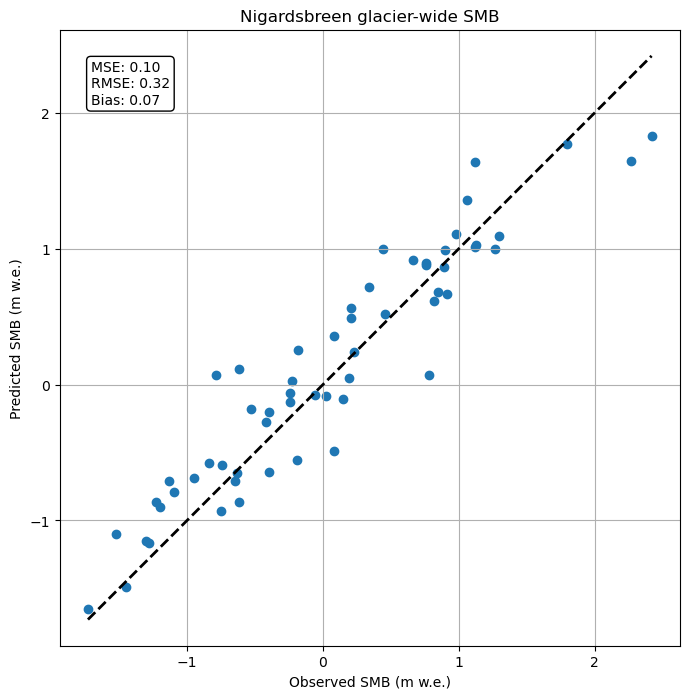

In [188]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

x = df_glacierwide['obs']
y = df_glacierwide['B_pred']

# Calculate MSE, RMSE and bias
mse = mean_squared_error(x, y)
rmse = np.sqrt(mse)
bias = np.mean(y - x)

# Create the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, label='')

# Annotate the plot with MSE, RMSE, and bias
textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nBias: {bias:.2f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Plot the line y=x to indicate the line through zero
min_val = min(min(x), min(y))
max_val = max(max(x), max(y))
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', linewidth=2)

# Set axis labels and title
plt.xlabel('Observed SMB (m w.e.)')
plt.ylabel('Predicted SMB (m w.e.)')
plt.title('Nigardsbreen glacier-wide SMB')

# Set axis to be equal
plt.axis('equal')

# Show the plot
#plt.legend()
plt.grid(True)
plt.show()
